### Preparation

In [ ]:
# import libraries needed
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Mount the Google Drive to get the datasets uploaded
# If not using Google Drive, please change the file path under cells of Dataset: digits
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Function: get tensor from npz file

In [ ]:
def get_tensor(path):
    data = np.load(path)
    train_X = torch.from_numpy(data['train_X']).float()
    train_Y = torch.from_numpy(data['train_y']).long()
    test_X = torch.from_numpy(data['test_X']).float()
    test_Y = torch.from_numpy(data['test_y']).long()
    return train_X, train_Y, test_X, test_Y

### Function: create datasets by SubsetRandomSampler and DataLoader

In [ ]:
# Create training, validation and testing dataset by SubsetRandomSampler and DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data as Data

def create_datasets(batch_size, train_X, train_Y, test_X, test_Y):
    # Percentage of training set to use as validation
    valid_size = 0.2

    # Transform Tensors to TensorDataset
    train_data = Data.TensorDataset(train_X, train_Y)
    test_data = Data.TensorDataset(test_X, test_Y)
    
    # Slice data randomly for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # Define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # Load training, validation and testing data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)
    
    return train_loader, valid_loader, test_loader

### Class: network

In [ ]:
class Net_multi(nn.Module):

    def __init__(self, h1, h2):
        super(Net_multi, self).__init__()
        self.fc1 = nn.Linear(8 * 8, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim = 1)
        return x

### Function: train the model

In [ ]:
def train_model(model, n_epochs, es_thres, patience):
    
    # Track the losses during trainings
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = [] 

    # Track the accuracy during trainings
    train_acc = []
    valid_acc = []
    avg_train_acc = []
    avg_valid_acc = [] 

    # Set up counter for early stopping
    es_counter = 0
    
    for epoch in range(1, n_epochs + 1):
        # Train the model
        model.train()
        for X, Y in train_loader:
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()
            # Record training loss & accuracy
            train_losses.append(loss.item())
            acc = 100 * torch.sum(Y==torch.max(output.data, 1)[1]).double() / len(Y)
            train_acc.append(acc.item())
 
        # Validate the model
        model.eval()
        for X, Y in valid_loader:
            output = model(X)
            loss = criterion(output, Y)
            # Record validation loss & accuracy
            valid_losses.append(loss.item())
            acc = 100 * torch.sum(Y==torch.max(output.data, 1)[1]).double() / len(Y)
            valid_acc.append(acc.item())
 
        # Calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        # Calculate average accuracy over an epoch
        train_acc = np.average(train_acc)
        valid_acc = np.average(valid_acc)
        avg_train_acc.append(train_acc)
        avg_valid_acc.append(valid_acc)

        # Format the printing message for tracking training progress
        epoch_len = len(str(n_epochs))
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}]', 
                     f'train_loss: {train_loss:.5f}',
                     f'valid_loss: {valid_loss:.5f}',
                     f'train_acc: {train_acc:.5f}',
                     f'valid_acc: {valid_acc:.5f}')
        print(print_msg)
        
        # Set up early stopping
        if epoch > 1:
            if ((avg_train_losses[-2] - avg_train_losses[-1]) < es_thres and (avg_valid_losses[-2] - avg_valid_losses[-1]) < es_thres) or \
               (train_acc == valid_acc == 100):
                es_counter += 1
            if es_counter >= patience:
                print("Early stopping")
                break

        # Clear lists to track next epoch
        train_losses = []
        valid_losses = []
        train_acc = []
        valid_acc = []

    return model, avg_train_acc[-1]

### Function: test the model

In [ ]:
# Install mlxtend for generating binary confusion matrix for multi-class
! pip install mlxtend

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, \
                            multilabel_confusion_matrix, accuracy_score, \
                            classification_report
import seaborn as sn
from sklearn.preprocessing import label_binarize
from mlxtend.evaluate import confusion_matrix as mlxtend_confusion_matrix

def test_model(model):
    test_acc = []
    prob_all = []
    label_all = []
    y_pred_all = []

    model.eval()
    for X, Y in test_loader:
        output = model(X)
        y_pred = torch.max(output.data, 1)[1]
        acc = 100 * torch.sum(Y==y_pred).double() / len(Y)
        test_acc.append(acc.item())
        prob_all.extend(output[:,1])
        label_all.extend(Y.numpy())
        y_pred_all.extend(y_pred.numpy())
  
    # constant for classes
    classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    classes_str = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

    # Obtain the testing accuracy
    test_acc = np.average(test_acc)
  
    # Generate multi-label confusion matrix
    cf_matrix = confusion_matrix(label_all, y_pred_all)
    df_cm = pd.DataFrame(cf_matrix,
                         index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Generate binary confusion matrix
    cm = mlxtend_confusion_matrix(y_target=label_all, 
                                  y_predicted=y_pred_all, 
                                  binary=True, 
                                  positive_label=1)
    sn.heatmap(cm, annot=True, cmap='Greens', fmt='d')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

    # Get classification report
    acc_score = accuracy_score(label_all, y_pred_all)
    report = classification_report(label_all, y_pred_all, target_names = classes_str)
    print(report)

    return net, test_acc, df_cm, acc_score, report

### Function: plot the accuracy with different number of hidden units

In [ ]:
import matplotlib.pyplot as plt

def plot_hidden_units(myDict, title):
    x = []
    y = []
    for key, value in myDict.items():
        x.append(key)
        y.append(value)
    num = np.arange(len(x))
    plt.figure(figsize=(10, 6))
    plt.bar(num, y)
    plt.xticks(num, x)
    plt.xlabel('No. of hidden units')
    plt.ylabel('Accuracy %')
    plt.title(title)
    plt.show()

### Set up of experiment in datasets

In [ ]:
H1 = [15, 25, 50]
H2 = [5, 10, 20]

### Dataset: digits

In [ ]:
data = 'digits'
train_X, train_Y, test_X, test_Y = get_tensor(f'/content/drive/My Drive/HKUST/MSBD5002/datasets/multi-class/{data}.npz')

# Create empty dictionaries for storing data
digits_train_acc = {}
digits_test_acc = {}
digits_test_AUC = {}
digits_time = {}
digits_acc_score = {}

In [ ]:
# Hyperparameters from training
batch_size = 300
n_epochs = 1000
patience = 20
es_thres = 0.000001

# Create datasets by batches
train_loader, valid_loader, test_loader = create_datasets(batch_size, train_X, train_Y, test_X, test_Y)

******************** Hidden Unit 1: 15, Hidden Unit 2: 5 ********************
('[   1/1000]', 'train_loss: 2.29997', 'valid_loss: 2.30208', 'train_acc: 10.86667', 'valid_acc: 8.01394')
('[   2/1000]', 'train_loss: 2.29321', 'valid_loss: 2.29611', 'train_acc: 11.00000', 'valid_acc: 9.40767')
('[   3/1000]', 'train_loss: 2.28656', 'valid_loss: 2.29062', 'train_acc: 11.80000', 'valid_acc: 10.10453')
('[   4/1000]', 'train_loss: 2.28031', 'valid_loss: 2.28502', 'train_acc: 12.36667', 'valid_acc: 10.10453')
('[   5/1000]', 'train_loss: 2.27348', 'valid_loss: 2.27931', 'train_acc: 12.81667', 'valid_acc: 11.14983')
('[   6/1000]', 'train_loss: 2.26699', 'valid_loss: 2.27312', 'train_acc: 13.71667', 'valid_acc: 13.93728')
('[   7/1000]', 'train_loss: 2.25867', 'valid_loss: 2.26719', 'train_acc: 16.86667', 'valid_acc: 13.58885')
('[   8/1000]', 'train_loss: 2.25072', 'valid_loss: 2.26055', 'train_acc: 19.15000', 'valid_acc: 15.67944')
('[   9/1000]', 'train_loss: 2.24317', 'valid_loss: 2.25393'

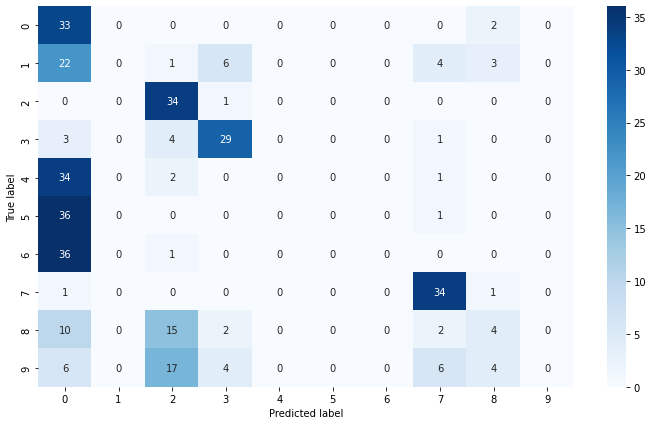

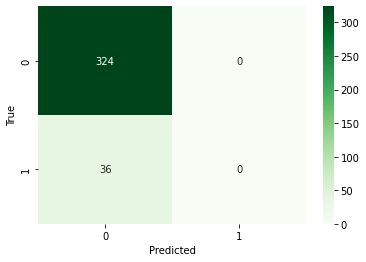

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.18      0.94      0.31        35
           1       0.00      0.00      0.00        36
           2       0.46      0.97      0.62        35
           3       0.69      0.78      0.73        37
           4       0.00      0.00      0.00        37
           5       0.00      0.00      0.00        37
           6       0.00      0.00      0.00        37
           7       0.69      0.94      0.80        36
           8       0.29      0.12      0.17        33
           9       0.00      0.00      0.00        37

    accuracy                           0.37       360
   macro avg       0.23      0.38      0.26       360
weighted avg       0.23      0.37      0.26       360

---------- Accuracy of testing in Hidden Unit 15: 35.66666666666667%---------- 
******************** Hidden Unit 1: 15, Hidden Unit 2: 10 ********************
('[   1/1000]', 'train_loss: 2.30643', 'valid_loss: 2.29958', 'train_acc: 15.23333

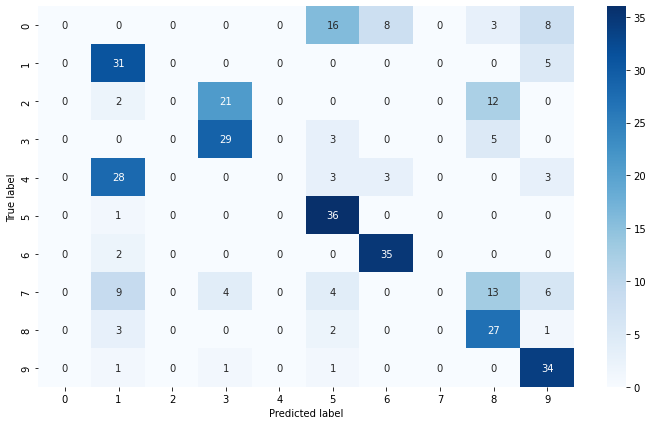

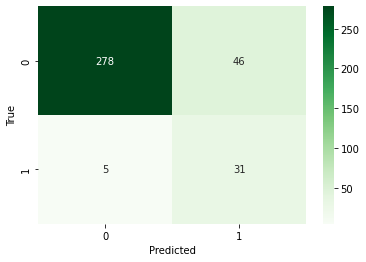

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.40      0.86      0.55        36
           2       0.00      0.00      0.00        35
           3       0.53      0.78      0.63        37
           4       0.00      0.00      0.00        37
           5       0.55      0.97      0.71        37
           6       0.76      0.95      0.84        37
           7       0.00      0.00      0.00        36
           8       0.45      0.82      0.58        33
           9       0.60      0.92      0.72        37

    accuracy                           0.53       360
   macro avg       0.33      0.53      0.40       360
weighted avg       0.33      0.53      0.41       360

---------- Accuracy of testing in Hidden Unit 15: 54.0%---------- 
******************** Hidden Unit 1: 15, Hidden Unit 2: 20 ********************
('[   1/1000]', 'train_loss: 2.30107', 'valid_loss: 2.28998', 'train_acc: 10.56667', 'valid_acc

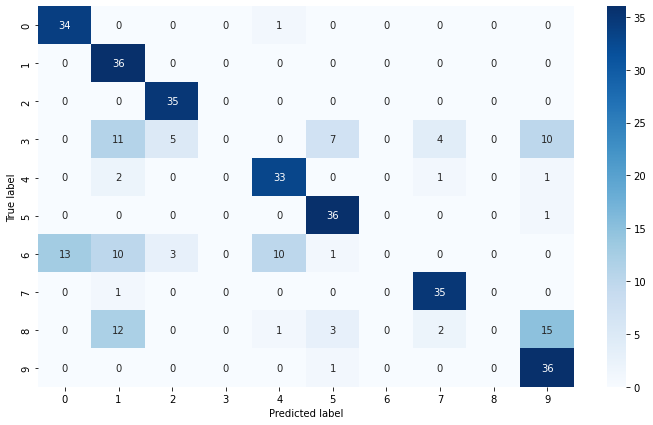

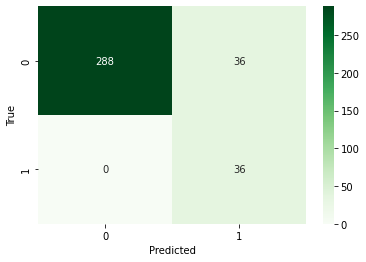

              precision    recall  f1-score   support

           0       0.72      0.97      0.83        35
           1       0.50      1.00      0.67        36
           2       0.81      1.00      0.90        35
           3       0.00      0.00      0.00        37
           4       0.73      0.89      0.80        37
           5       0.75      0.97      0.85        37
           6       0.00      0.00      0.00        37
           7       0.83      0.97      0.90        36
           8       0.00      0.00      0.00        33
           9       0.57      0.97      0.72        37

    accuracy                           0.68       360
   macro avg       0.49      0.68      0.57       360
weighted avg       0.49      0.68      0.57       360

---------- Accuracy of testing in Hidden Unit 15: 69.5%---------- 
******************** Hidden Unit 1: 25, Hidden Unit 2: 5 ********************
('[   1/1000]', 'train_loss: 2.29549', 'valid_loss: 2.28603', 'train_acc: 10.18333', 'valid_acc:

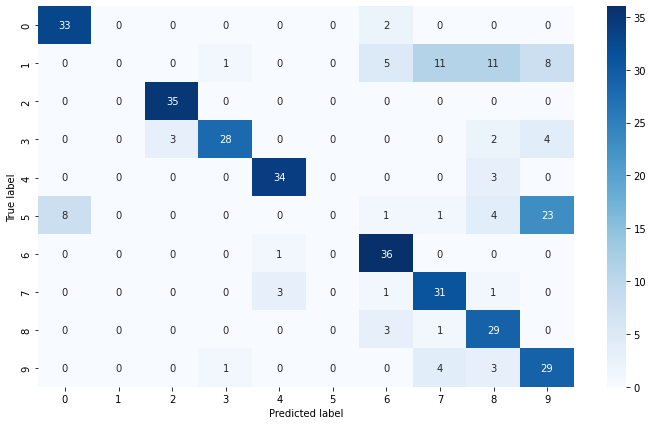

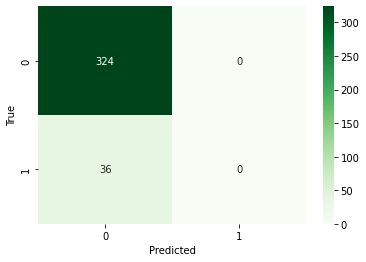

              precision    recall  f1-score   support

           0       0.80      0.94      0.87        35
           1       0.00      0.00      0.00        36
           2       0.92      1.00      0.96        35
           3       0.93      0.76      0.84        37
           4       0.89      0.92      0.91        37
           5       0.00      0.00      0.00        37
           6       0.75      0.97      0.85        37
           7       0.65      0.86      0.74        36
           8       0.55      0.88      0.67        33
           9       0.45      0.78      0.57        37

    accuracy                           0.71       360
   macro avg       0.60      0.71      0.64       360
weighted avg       0.59      0.71      0.64       360

---------- Accuracy of testing in Hidden Unit 25: 71.83333333333333%---------- 
******************** Hidden Unit 1: 25, Hidden Unit 2: 10 ********************
('[   1/1000]', 'train_loss: 2.30451', 'valid_loss: 2.29516', 'train_acc: 7.53333'

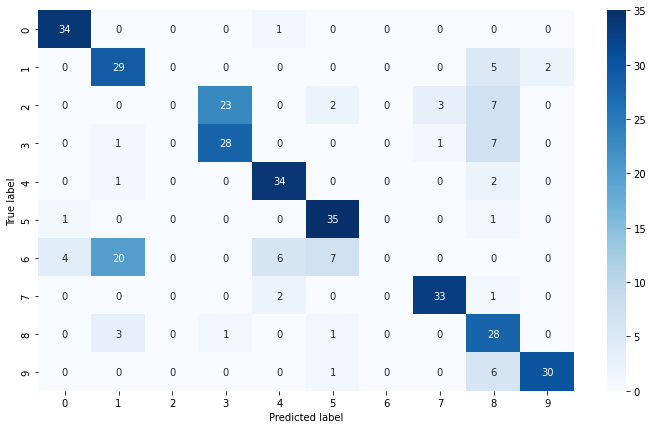

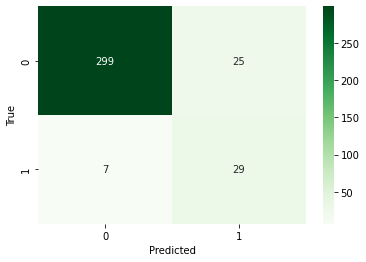

              precision    recall  f1-score   support

           0       0.87      0.97      0.92        35
           1       0.54      0.81      0.64        36
           2       0.00      0.00      0.00        35
           3       0.54      0.76      0.63        37
           4       0.79      0.92      0.85        37
           5       0.76      0.95      0.84        37
           6       0.00      0.00      0.00        37
           7       0.89      0.92      0.90        36
           8       0.49      0.85      0.62        33
           9       0.94      0.81      0.87        37

    accuracy                           0.70       360
   macro avg       0.58      0.70      0.63       360
weighted avg       0.58      0.70      0.63       360

---------- Accuracy of testing in Hidden Unit 25: 71.83333333333334%---------- 
******************** Hidden Unit 1: 25, Hidden Unit 2: 20 ********************
('[   1/1000]', 'train_loss: 2.29155', 'valid_loss: 2.29517', 'train_acc: 11.48333

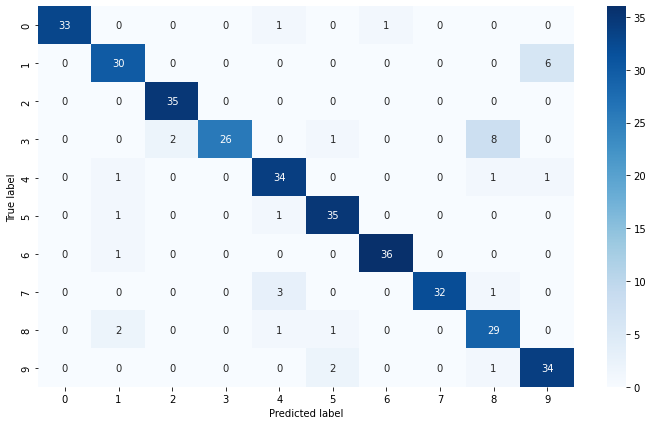

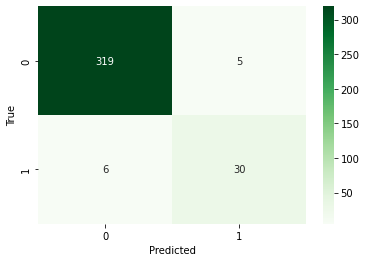

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        35
           1       0.86      0.83      0.85        36
           2       0.95      1.00      0.97        35
           3       1.00      0.70      0.83        37
           4       0.85      0.92      0.88        37
           5       0.90      0.95      0.92        37
           6       0.97      0.97      0.97        37
           7       1.00      0.89      0.94        36
           8       0.72      0.88      0.79        33
           9       0.83      0.92      0.87        37

    accuracy                           0.90       360
   macro avg       0.91      0.90      0.90       360
weighted avg       0.91      0.90      0.90       360

---------- Accuracy of testing in Hidden Unit 25: 92.0%---------- 
******************** Hidden Unit 1: 50, Hidden Unit 2: 5 ********************
('[   1/1000]', 'train_loss: 2.30188', 'valid_loss: 2.28085', 'train_acc: 13.35000', 'valid_acc:

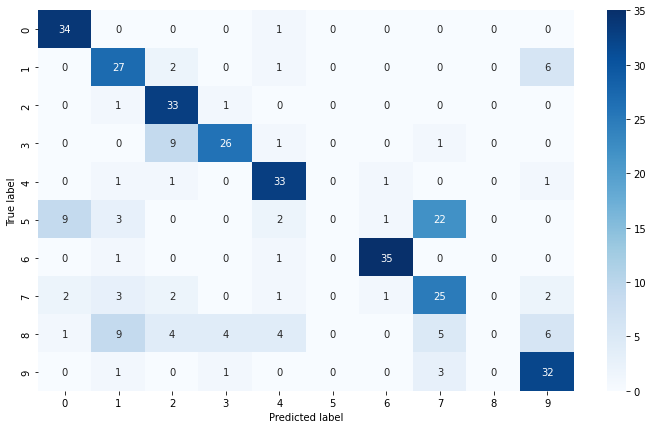

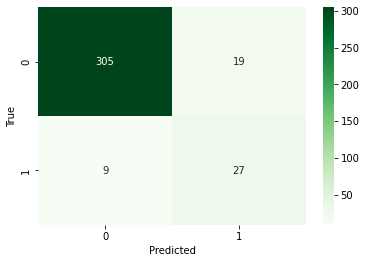

              precision    recall  f1-score   support

           0       0.74      0.97      0.84        35
           1       0.59      0.75      0.66        36
           2       0.65      0.94      0.77        35
           3       0.81      0.70      0.75        37
           4       0.75      0.89      0.81        37
           5       0.00      0.00      0.00        37
           6       0.92      0.95      0.93        37
           7       0.45      0.69      0.54        36
           8       0.00      0.00      0.00        33
           9       0.68      0.86      0.76        37

    accuracy                           0.68       360
   macro avg       0.56      0.68      0.61       360
weighted avg       0.56      0.68      0.61       360

---------- Accuracy of testing in Hidden Unit 50: 68.83333333333334%---------- 
******************** Hidden Unit 1: 50, Hidden Unit 2: 10 ********************
('[   1/1000]', 'train_loss: 2.30753', 'valid_loss: 2.29304', 'train_acc: 8.76667'

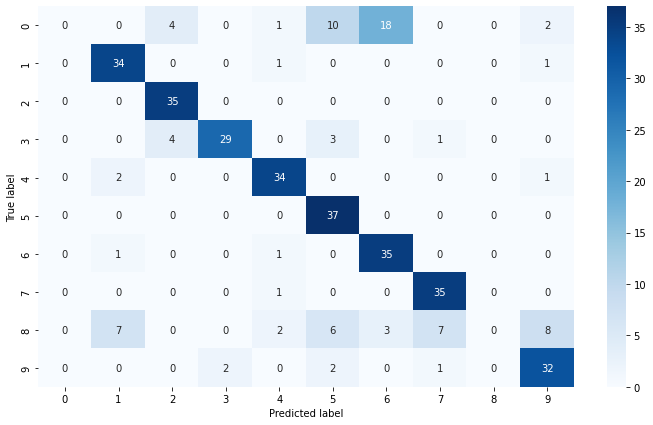

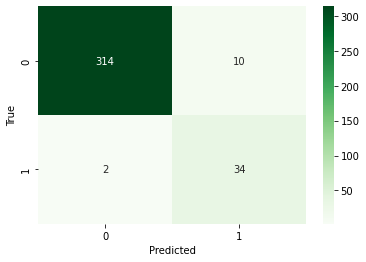

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.77      0.94      0.85        36
           2       0.81      1.00      0.90        35
           3       0.94      0.78      0.85        37
           4       0.85      0.92      0.88        37
           5       0.64      1.00      0.78        37
           6       0.62      0.95      0.75        37
           7       0.80      0.97      0.88        36
           8       0.00      0.00      0.00        33
           9       0.73      0.86      0.79        37

    accuracy                           0.75       360
   macro avg       0.62      0.74      0.67       360
weighted avg       0.62      0.75      0.68       360

---------- Accuracy of testing in Hidden Unit 50: 75.83333333333334%---------- 
******************** Hidden Unit 1: 50, Hidden Unit 2: 20 ********************
('[   1/1000]', 'train_loss: 2.30653', 'valid_loss: 2.29831', 'train_acc: 12.45000

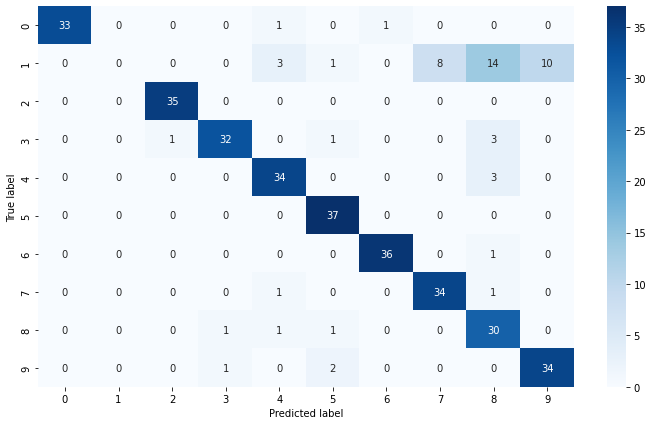

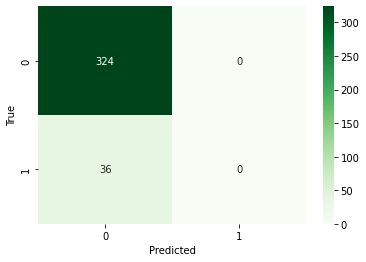

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        35
           1       0.00      0.00      0.00        36
           2       0.97      1.00      0.99        35
           3       0.94      0.86      0.90        37
           4       0.85      0.92      0.88        37
           5       0.88      1.00      0.94        37
           6       0.97      0.97      0.97        37
           7       0.81      0.94      0.87        36
           8       0.58      0.91      0.71        33
           9       0.77      0.92      0.84        37

    accuracy                           0.85       360
   macro avg       0.78      0.85      0.81       360
weighted avg       0.78      0.85      0.81       360

---------- Accuracy of testing in Hidden Unit 50: 85.5%---------- 


In [ ]:
# Loop with differnt number of hidden units
for i in H1:
    for j in H2:
        print(f'******************** Hidden Unit 1: {i}, Hidden Unit 2: {j} ********************')
        net = Net_multi(i, j)
        # Set up optimizer and loss function
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
        # Train the model
        time_start = time.time()
        net, train_acc = train_model(net, n_epochs, es_thres, patience)
        time_end = time.time()
        time_used = time_end - time_start
        digits_time[(i, j)] = time_used
        digits_train_acc[(i, j)] = train_acc
        print(f'---------- End of training (time: {time_used}) ----------')
        # Test the model
        net, test_acc, df_cm, acc_score, report = test_model(net)
        digits_test_acc[(i, j)] = test_acc
        # digits_test_AUC[i] = test_AUC
        digits_acc_score[(i, j)] = acc_score

        print(f'---------- Accuracy of testing in Hidden Unit {i}: {test_acc}%---------- ')

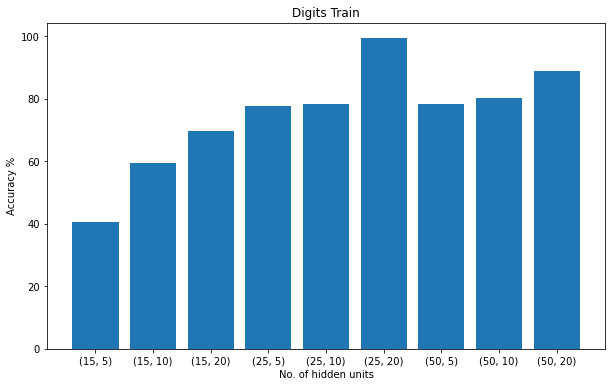

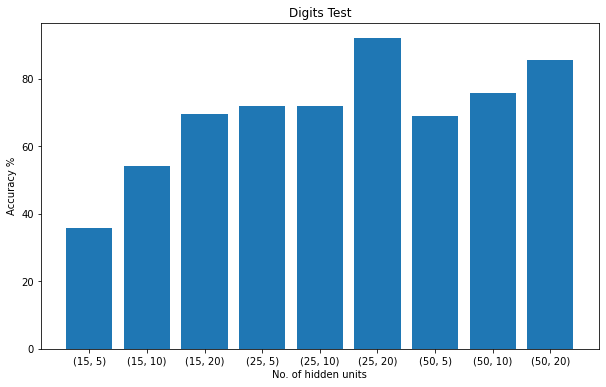

In [ ]:
# Plot the accuracy of different number of hidden units
plot_hidden_units(digits_train_acc, 'Digits Train')
plot_hidden_units(digits_test_acc, 'Digits Test')

In [ ]:
# Get the best number of hidden units
digits_best_n = max(digits_test_acc, key=digits_test_acc.get)
print(digits_test_acc)
print(digits_best_n)

{(15, 5): 35.66666666666667, (15, 10): 54.0, (15, 20): 69.5, (25, 5): 71.83333333333333, (25, 10): 71.83333333333334, (25, 20): 92.0, (50, 5): 68.83333333333334, (50, 10): 75.83333333333334, (50, 20): 85.5}
(25, 20)


### Summary table

In [ ]:
df_summary = pd.DataFrame()
df_summary['dataset'] = [data]
df_summary['best_n_hidden'] = [digits_best_n]
df_summary['train_accuracy%'] = [digits_train_acc[digits_best_n]]
df_summary['test_accuracy%'] = [digits_test_acc[digits_best_n]]
df_summary['accuracy score'] = [digits_acc_score[digits_best_n]]
df_summary['train_time'] = [digits_time[digits_best_n]]
df_summary

,dataset,best_n_hidden,train_accuracy%,test_accuracy%,accuracy score,train_time
0,digits,"(25, 20)",99.35,92.0,0.9,3.117411


In [ ]:
df_summary2 = pd.DataFrame(columns=['n_hidden', 'train_accuracy%', 'test_accuracy%', 'accuracy score', 'train_time'])
idx = 0
for h in digits_test_acc.keys():
    df_summary2.loc[idx] = [h, digits_train_acc[h], digits_test_acc[h], digits_acc_score[h], digits_time[h]]
    idx += 1
df_summary2

,n_hidden,train_accuracy%,test_accuracy%,accuracy score,train_time
0,"(15, 5)",40.500000,35.666667,0.372222,3.622261
1,"(15, 10)",59.283333,54.000000,0.533333,2.725217
2,"(15, 20)",69.683333,69.500000,0.680556,2.668207
3,"(25, 5)",77.766667,71.833333,0.708333,5.039432
4,"(25, 10)",78.166667,71.833333,0.697222,3.247174
5,"(25, 20)",99.350000,92.000000,0.900000,3.117411
6,"(50, 5)",78.383333,68.833333,0.680556,6.939860
7,"(50, 10)",80.350000,75.833333,0.752778,3.169997
8,"(50, 20)",88.983333,85.500000,0.847222,2.594220
